## 1. IMPORT LIBRARIES & DATA

In [1]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

In [2]:
# Configure API key 
quandl.ApiConfig.api_key = 'hytzJejvprUhPUM1TBAy'

In [3]:
# 'Apartment rental in Germany' dataframe was not suitable for time series analysis. So, I chose to use another dataset
# for time series analysis from quandl.
data = quandl.get_table('ZILLOW/DATA')

In [4]:
data.head()

,indicator_id,region_id,date,value
None,,,,
0,ZSFH,99999,2023-08-31,487125.108603
1,ZSFH,99999,2023-07-31,488622.145790
2,ZSFH,99999,2023-06-30,488664.469915
3,ZSFH,99999,2023-05-31,487177.043727
4,ZSFH,99999,2023-04-30,483911.059168


In [5]:
#dropping the columns which are useful
data=data.drop(columns=['indicator_id','region_id'])

In [6]:
data.head()

,date,value
None,,
0,2023-08-31,487125.108603
1,2023-07-31,488622.145790
2,2023-06-30,488664.469915
3,2023-05-31,487177.043727
4,2023-04-30,483911.059168


In [8]:
data['date'].value_counts(dropna = False)

2017-06-30    41
2017-04-30    41
2017-07-31    41
2017-08-31    41
2017-09-30    41
              ..
1997-02-28     8
1997-03-31     8
1997-05-31     8
1997-06-30     8
1996-01-31     8
Name: date, Length: 332, dtype: int64

In [7]:
# converting date to date-time format
data['date']=pd.to_datetime(data['date'], format='%d/%m/%Y')

In [8]:
data=data.set_index('date')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10000 entries, 2023-08-31 to 2015-05-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   10000 non-null  float64
dtypes: float64(1)
memory usage: 156.2 KB


In [10]:
data.shape

(10000, 1)

In [11]:
data.head()

,value
date,
2023-08-31,487125.108603
2023-07-31,488622.145790
2023-06-30,488664.469915
2023-05-31,487177.043727
2023-04-30,483911.059168


In [12]:
data=data[data.index < '2021-01-01']

In [13]:
# Resample data to monthly frequency (you can choose a different frequency and different aggregation)
data_monthly = data.resample('M').mean()

In [14]:
data_monthly.head()

,value
date,
1996-01-31,141962.00
1996-02-29,142601.25
1996-03-31,142902.50
1996-04-30,143683.00
1996-05-31,144764.75


## 3-CREATE A LINE CHART

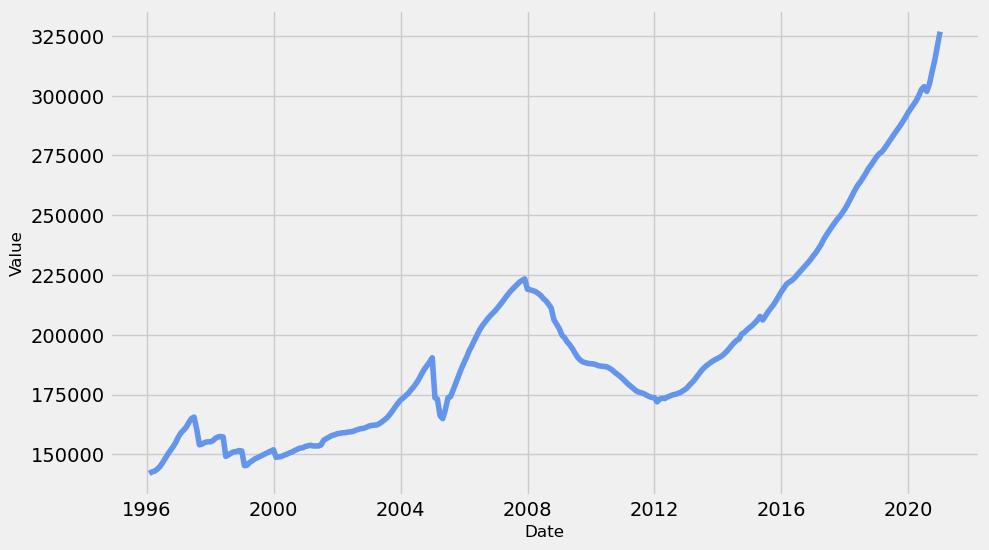

In [15]:
plt.figure(figsize = (10,6))
plt.plot(data_monthly, color = 'cornflowerblue')
plt.xlabel('Date', size = 12)
plt.ylabel('Value', size = 12)
plt.show()

## DECOMPOSE DATA COMPONENTS

In [16]:
# Decompose time series using additive model
decomposition = sm.tsa.seasonal_decompose(data_monthly, model='additive')

In [17]:
# Define fixed size for all charts
from pylab import rcParams 
rcParams['figure.figsize'] = 18, 7

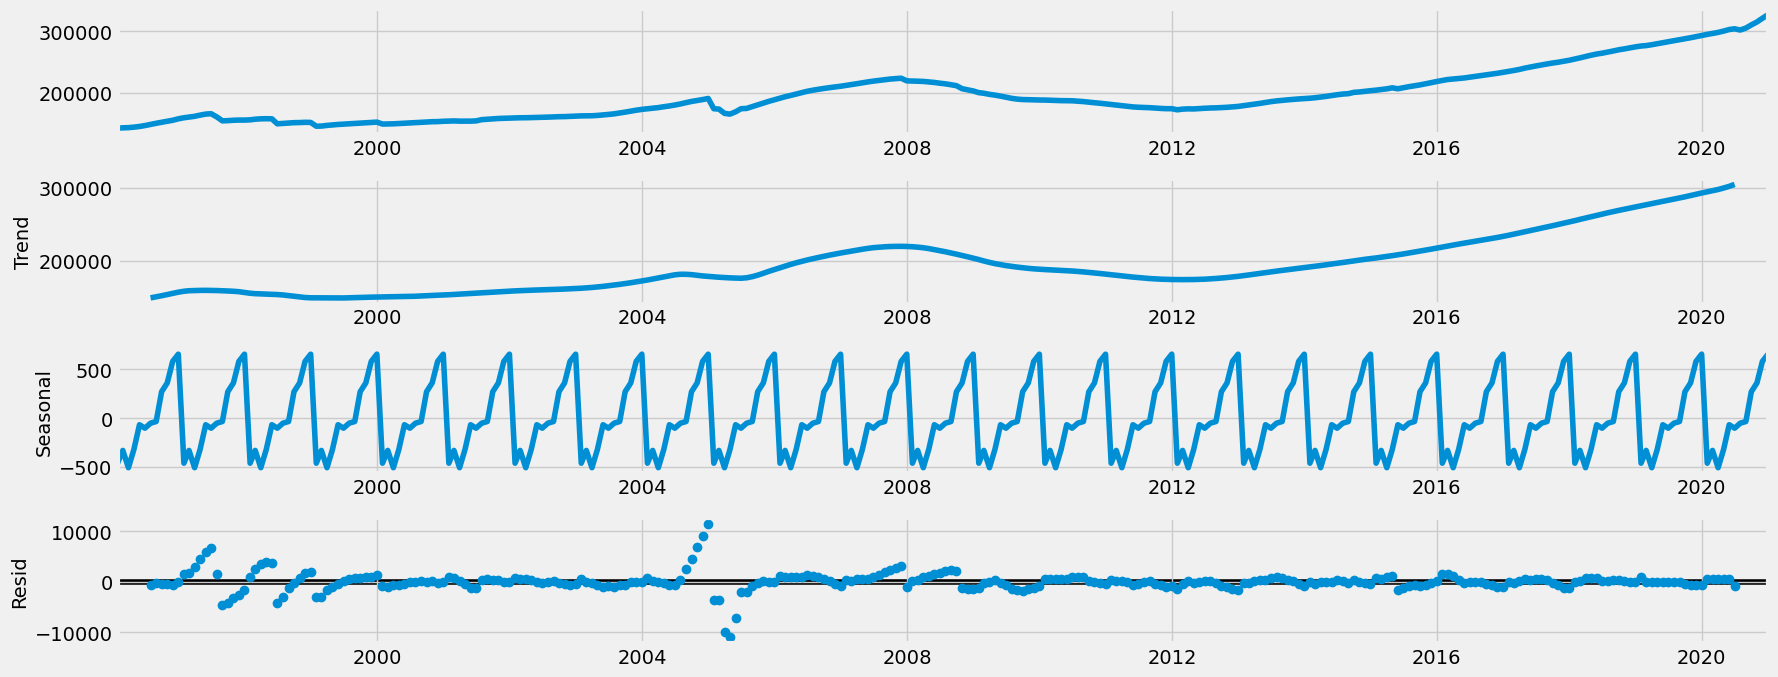

In [18]:
# Plot separate components

decomposition.plot()
plt.show()

The level and trend appears almmost same except of some points(before 2000 & after 2004). It has an upward trend after 2012.
There is also seasonality present in this data, represented by the spiked curve that changes at regular intervals.
Finally, the residual chart shows the noise of the data, which I think apart from few points the plots are fairly closely centered around zero, there isn't an immense amount.

## DICKEY FULLER TEST

In [19]:
# Import the adfuller() function
from statsmodels.tsa.stattools import adfuller 

# Define the function
def dickey_fuller(timeseries): 
    
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_monthly['value'])

Dickey-Fuller Stationarity test:
Test Statistic                   2.372558
p-value                          0.998997
Number of Lags Used              2.000000
Number of Observations Used    297.000000
Critical Value (1%)             -3.452561
Critical Value (5%)             -2.871321
Critical Value (10%)            -2.571982
dtype: float64


Test statistic value is larger than critical value & p-value is also greater than 0.05. That means I can't reject null hypothesis.

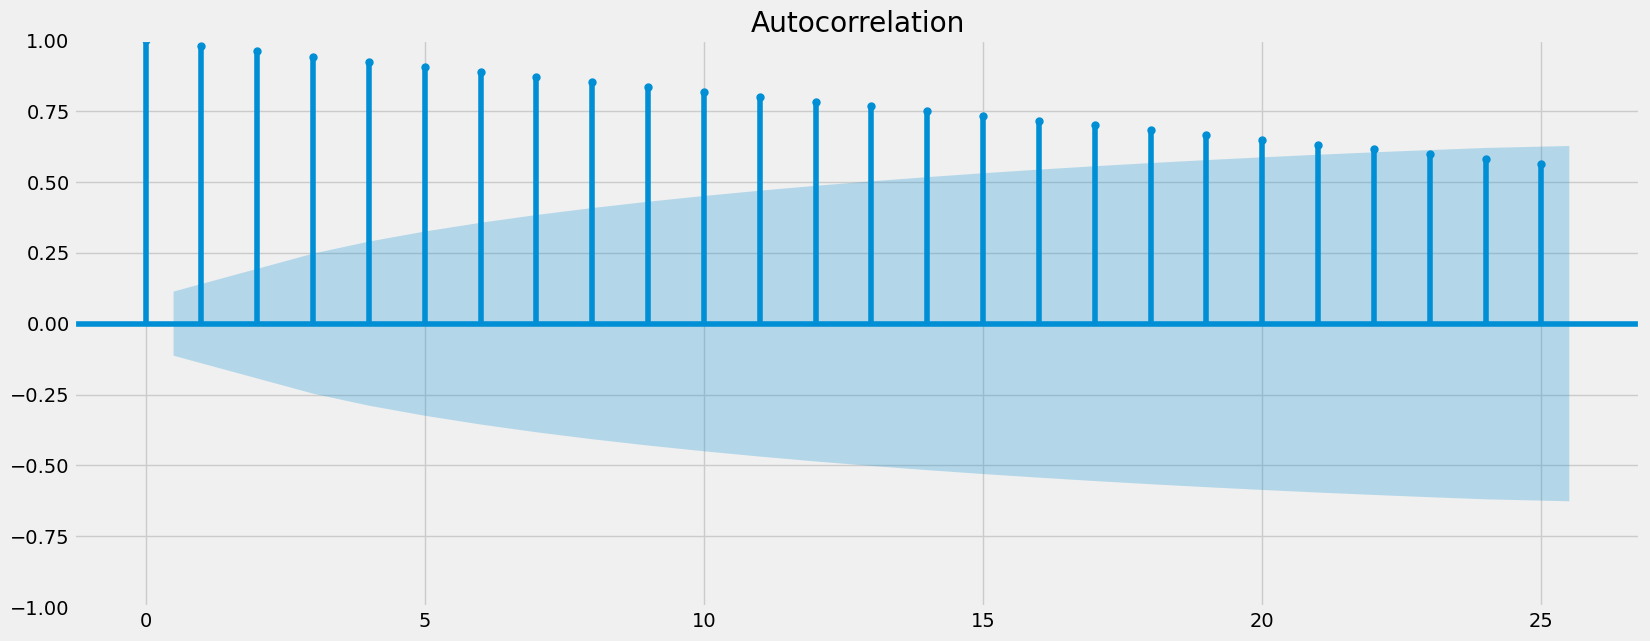

In [20]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
plot_acf(data_monthly)
plt.show()

There are many lags above the confidence interval edge, which means there are many lags significantly correlated with each other (or there is a lot of autocorrelated data, supporting the result of the Dickey-Fuller test)

## ROUND OF DIFFERENCING

In [21]:
data_diff = data_monthly - data_monthly.shift(1) 

In [22]:
# Remove missing values that come as a result of differencing
data_diff.dropna(inplace = True)

In [23]:
data_diff.head()

,value
date,
1996-02-29,639.250
1996-03-31,301.250
1996-04-30,780.500
1996-05-31,1081.750
1996-06-30,1520.375


In [24]:
data_diff.columns

Index(['value'], dtype='object')

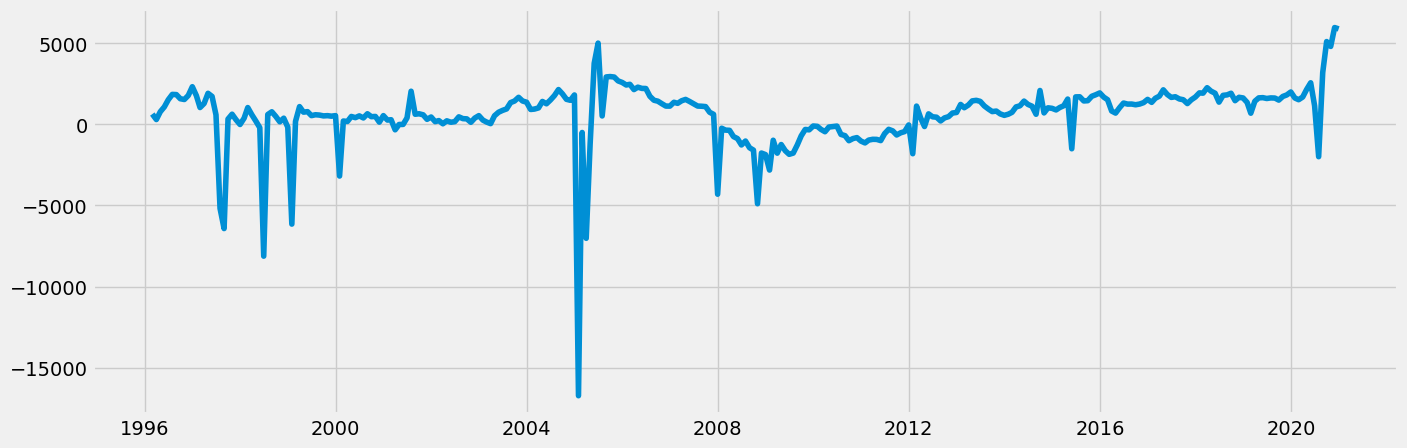

In [25]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [26]:
#Re-run Dickey-Fuller test
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                  -2.631616
p-value                          0.086637
Number of Lags Used              9.000000
Number of Observations Used    289.000000
Critical Value (1%)             -3.453182
Critical Value (5%)             -2.871593
Critical Value (10%)            -2.572127
dtype: float64


Test statistic is now smaller than both the 5% and 10% Critical Values but p-valueis still greater than 0.05. So additional round of differencing is needed.

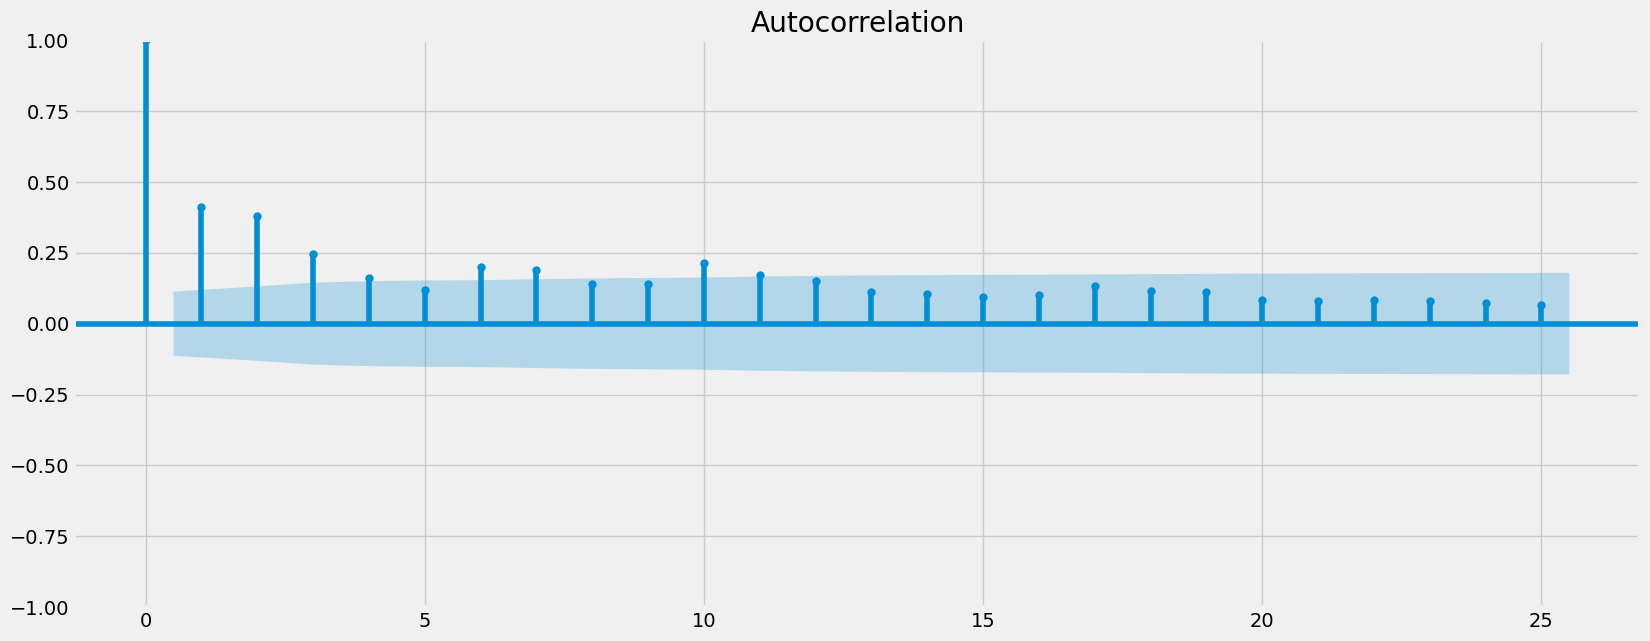

In [27]:
plot_acf(data_diff)
plt.show()

## ADDITIONAL ROUND OF DIFFERENCING

In [28]:
data_diff1 = data_diff - data_diff.shift(1) 

In [29]:
# Remove missing values that come as a result of differencing
data_diff1.dropna(inplace = True)

In [30]:
data_diff1.head()

,value
date,
1996-03-31,-338.000
1996-04-30,479.250
1996-05-31,301.250
1996-06-30,438.625
1996-07-31,331.500


In [31]:
data_diff1.columns

Index(['value'], dtype='object')

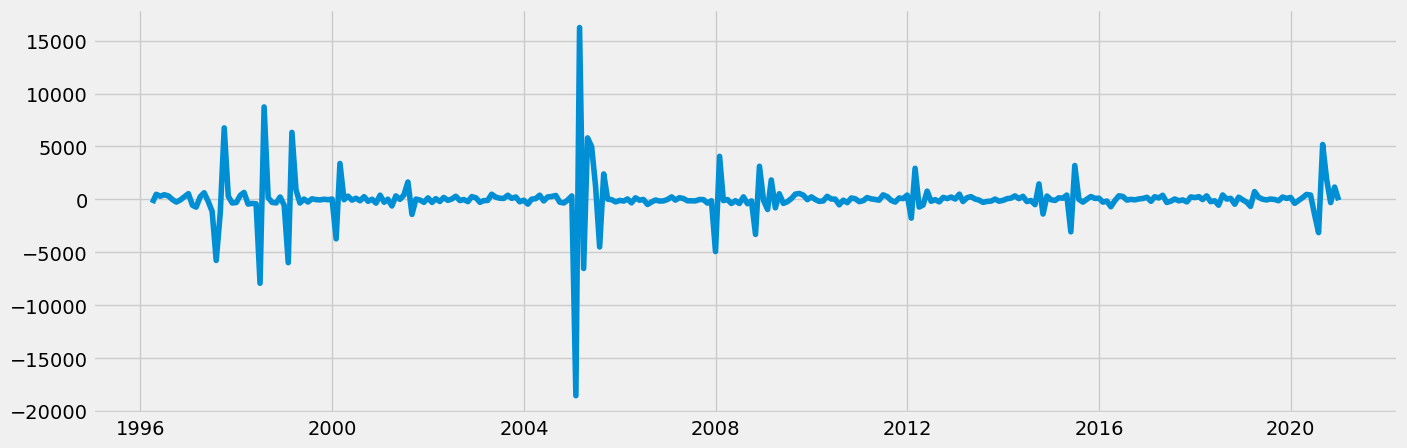

In [32]:
# Check out what the differencing did to the time-series curve

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff1)

In [33]:
#Re-run Dickey-Fuller test
dickey_fuller(data_diff1)

Dickey-Fuller Stationarity test:
Test Statistic                -8.815820e+00
p-value                        1.935697e-14
Number of Lags Used            9.000000e+00
Number of Observations Used    2.880000e+02
Critical Value (1%)           -3.453262e+00
Critical Value (5%)           -2.871628e+00
Critical Value (10%)          -2.572146e+00
dtype: float64


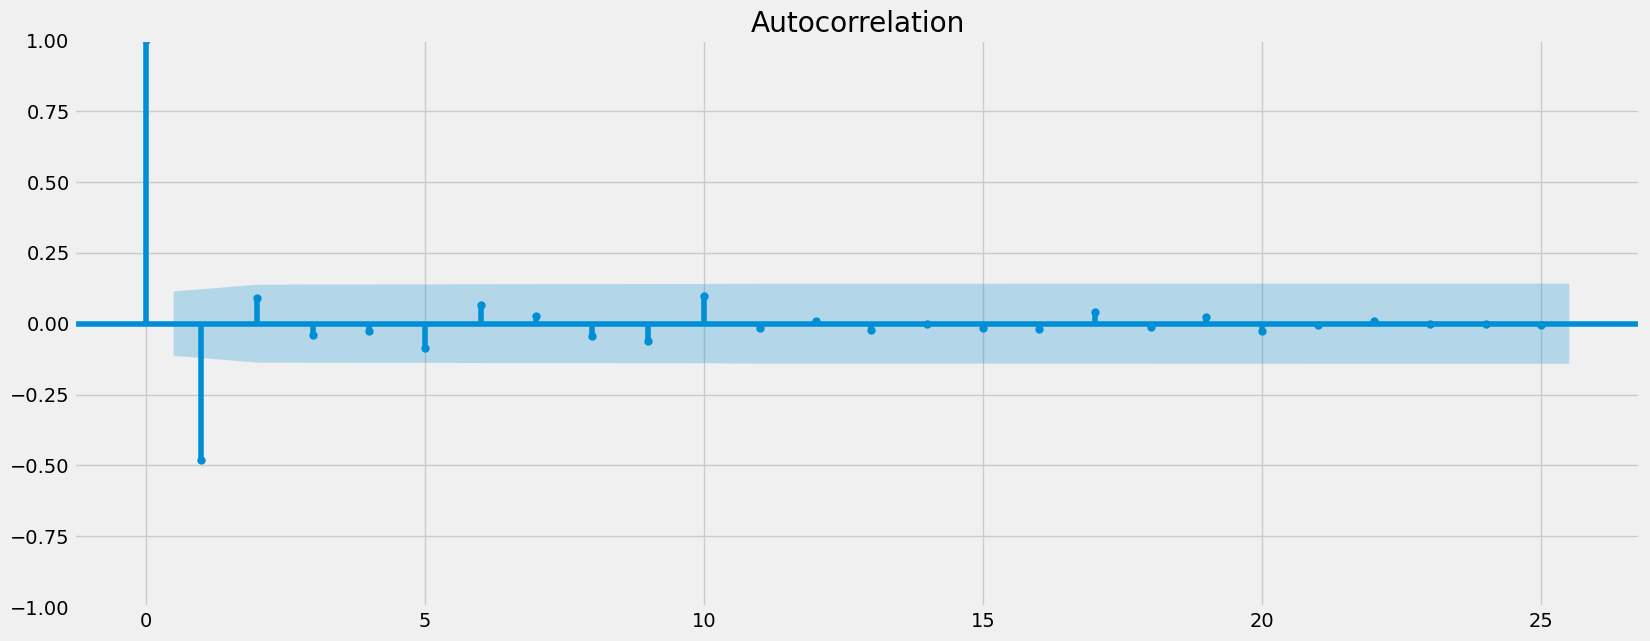

In [34]:
plot_acf(data_diff1)
plt.show()

While there are still a few lags above the blue confidence interval, there are less than 10 of them so I will choose to stop here! and P-value is smaller than 0.05 and so is test statistic smaller than critical value.